In [58]:
import pandas as pd

# Load the datasets with date parsing
btc_df = pd.read_csv('/content/drive/MyDrive/Python Project/coin_Bitcoin.csv', parse_dates=['Date'])
eth_df = pd.read_csv('/content/drive/MyDrive/Python Project/coin_Ethereum.csv', parse_dates=['Date'])
sol_df = pd.read_csv('/content/drive/MyDrive/Python Project/coin_Solana.csv', parse_dates=['Date'])

# Select relevant columns and rename for consistency
btc_df = btc_df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Marketcap']].rename(
    columns={'Close': 'btc_close'}
)
eth_df = eth_df[['Date', 'Close']].rename(columns={'Close': 'eth_close'})
sol_df = sol_df[['Date', 'Close']].rename(columns={'Close': 'sol_close'})

# Merge datasets on 'Date'
merged_df = pd.merge(btc_df, eth_df, on='Date', how='inner')
merged_df = pd.merge(merged_df, sol_df, on='Date', how='inner')

# Sort by date
merged_df.sort_values('Date', inplace=True)

# Save the merged dataset to a CSV file
merged_df.to_csv('/content/drive/MyDrive/Python Project/merged_cryptos.csv', index=False)

# Display the first few rows of the merged dataset
print(merged_df.head())


                 Date         Open         High          Low    btc_close  \
0 2020-04-11 23:59:59  6867.440452  6926.069634  6789.920702  6859.082963   
1 2020-04-12 23:59:59  6858.068025  7119.947062  6811.077900  6971.091591   
2 2020-04-13 23:59:59  6965.616638  6965.616638  6668.259764  6845.037697   
3 2020-04-14 23:59:59  6843.281777  6958.557224  6793.821209  6842.427861   
4 2020-04-15 23:59:59  6845.561717  6928.664370  6633.402692  6642.109893   

         Volume     Marketcap   eth_close  sol_close  
0  3.122209e+10  1.256516e+11  158.216024   0.776819  
1  3.575957e+10  1.277168e+11  161.142420   0.882507  
2  3.861931e+10  1.254222e+11  156.279549   0.777832  
3  3.411043e+10  1.253887e+11  157.596396   0.661925  
4  3.228831e+10  1.217319e+11  153.286893   0.646651  


In [32]:
# Percentage change
merged_df['btc_pct_change'] = merged_df['btc_close'].pct_change()
merged_df['eth_pct_change'] = merged_df['eth_close'].pct_change()
merged_df['sol_pct_change'] = merged_df['sol_close'].pct_change()

# Moving averages for Bitcoin
merged_df['btc_ma7'] = merged_df['btc_close'].rolling(window=7).mean()
merged_df['btc_ma30'] = merged_df['btc_close'].rolling(window=30).mean()

# Volatility Calculation for Bitcoin (added this line)
merged_df['btc_volatility'] = merged_df['btc_close'].rolling(window=7).std()

# Lag features
merged_df['btc_lag1'] = merged_df['btc_close'].shift(1)
merged_df['eth_lag1'] = merged_df['eth_close'].shift(1)
merged_df['sol_lag1'] = merged_df['sol_close'].shift(1)

# Drop rows with NaN values caused by rolling and lag calculations
merged_df.dropna(inplace=True)

# Define the target variable: Predict if Bitcoin's price increases the next day
merged_df['btc_target'] = (merged_df['btc_close'].shift(-1) > merged_df['btc_close']).astype(int)

# Drop the last row with NaN in target
merged_df.dropna(inplace=True)

In [33]:
from sklearn.model_selection import train_test_split

# Define features and target variable
features = [
    'btc_pct_change', 'eth_pct_change', 'sol_pct_change',
    'btc_ma7', 'btc_ma30', 'btc_volatility',
    'btc_lag1', 'eth_lag1', 'sol_lag1'
]
X = merged_df[features]
y = merged_df['btc_target']

# Split data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)



(315, 9) (79, 9)


In [34]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# Train XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Model Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:02:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Model Accuracy: 54.43%
              precision    recall  f1-score   support

           0       0.39      0.59      0.47        27
           1       0.71      0.52      0.60        52

    accuracy                           0.54        79
   macro avg       0.55      0.56      0.54        79
weighted avg       0.60      0.54      0.56        79



In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import VotingClassifier

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Ensemble: XGBoost and Random Forest
ensemble_model = VotingClassifier(
    estimators=[('xgb', xgb_model), ('rf', rf_model)],
    voting='soft'  # Use probabilities for more robust predictions
)
ensemble_model.fit(X_train, y_train)

# Make predictions with ensemble
y_pred_ensemble = ensemble_model.predict(X_test)

# Evaluate accuracy
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
classification_ensemble = classification_report(y_test, y_pred_ensemble)

print(f"Ensemble Model Accuracy: {accuracy_ensemble * 100:.2f}%")
print("Ensemble Classification Report:\n", classification_ensemble)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:11:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Ensemble Model Accuracy: 58.23%
Ensemble Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.63      0.51        27
           1       0.74      0.56      0.64        52

    accuracy                           0.58        79
   macro avg       0.58      0.59      0.57        79
weighted avg       0.63      0.58      0.59        79



In [44]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# Train XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:14:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 54.43%
              precision    recall  f1-score   support

           0       0.39      0.59      0.47        27
           1       0.71      0.52      0.60        52

    accuracy                           0.54        79
   macro avg       0.55      0.56      0.54        79
weighted avg       0.60      0.54      0.56        79



In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Build the model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Neural Network Accuracy: {accuracy * 100:.2f}%")


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.3830 - loss: 2213.3562 - val_accuracy: 0.4177 - val_loss: 71.9856
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4959 - loss: 1070.1053 - val_accuracy: 0.6582 - val_loss: 243.6123
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5151 - loss: 911.6030 - val_accuracy: 0.3418 - val_loss: 357.3267
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4696 - loss: 847.7589 - val_accuracy: 0.3291 - val_loss: 144.8683
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5188 - loss: 598.8248 - val_accuracy: 0.3418 - val_loss: 202.4170
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5685 - loss: 575.6748 - val_accuracy: 0.3418 - val_loss: 548.8196
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5120 - loss: 467.0509 - val_accuracy: 0.3418 - val_loss: 370.6811
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5564 - loss: 373.3304 - val_accurac

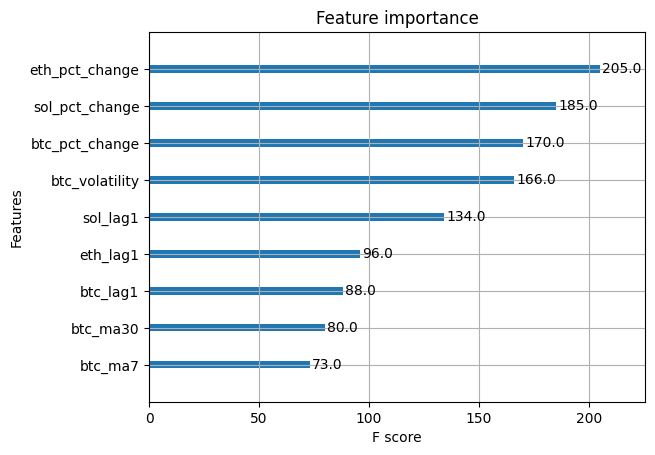

In [48]:
import matplotlib.pyplot as plt

# Plot feature importance
xgb.plot_importance(xgb_model, max_num_features=10)
plt.show()

In [53]:
!pip install ta


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=6d626e61b40417b5126630bb8b94f8180ef2d3961470aeebfe4ee89fee142bc3
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


##Visualizations


In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [59]:
# Load the merged cryptocurrency dataset
merged_df = pd.read_csv('/content/drive/MyDrive/Python Project/merged_cryptos.csv', parse_dates=['Date'])


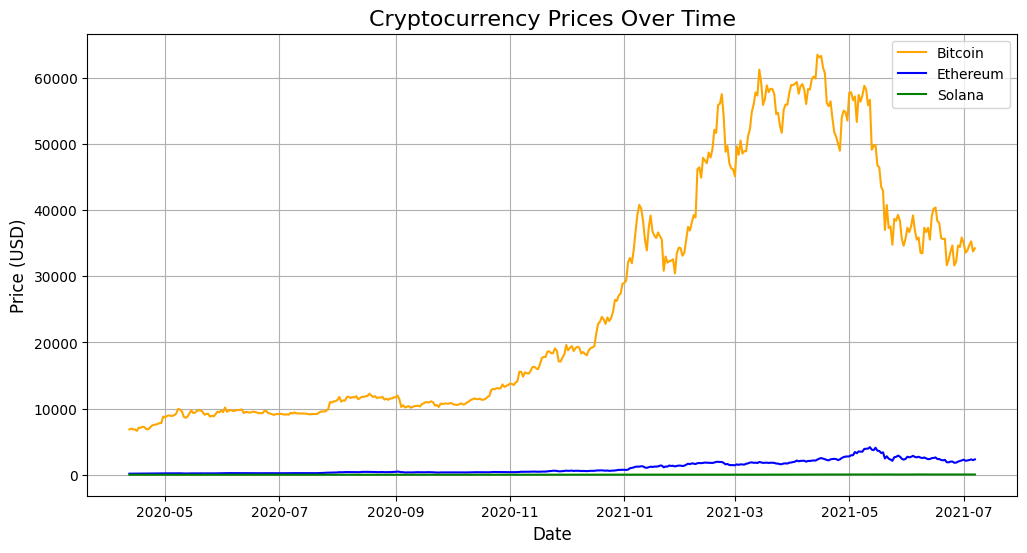

In [60]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df['Date'], merged_df['btc_close'], label='Bitcoin', color='orange')
plt.plot(merged_df['Date'], merged_df['eth_close'], label='Ethereum', color='blue')
plt.plot(merged_df['Date'], merged_df['sol_close'], label='Solana', color='green')
plt.title('Cryptocurrency Prices Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend()
plt.grid()
plt.savefig('crypto_prices_over_time.png')
plt.show()


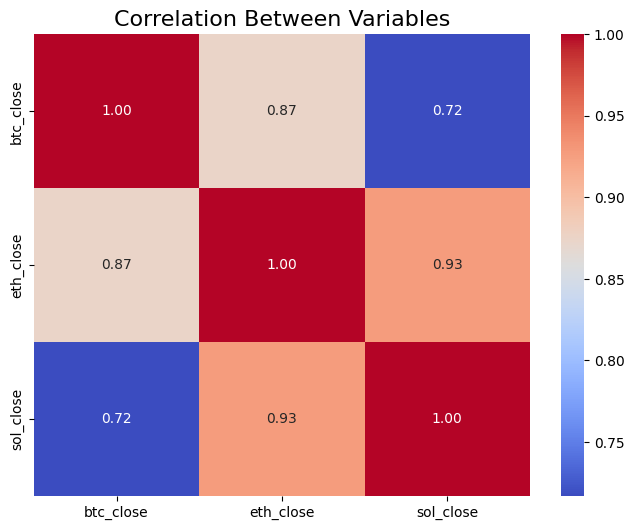

In [62]:
# Compute correlation matrix
correlation = merged_df[['btc_close', 'eth_close', 'sol_close']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Variables', fontsize=16)
plt.savefig('correlation_heatmap.png')
plt.show()


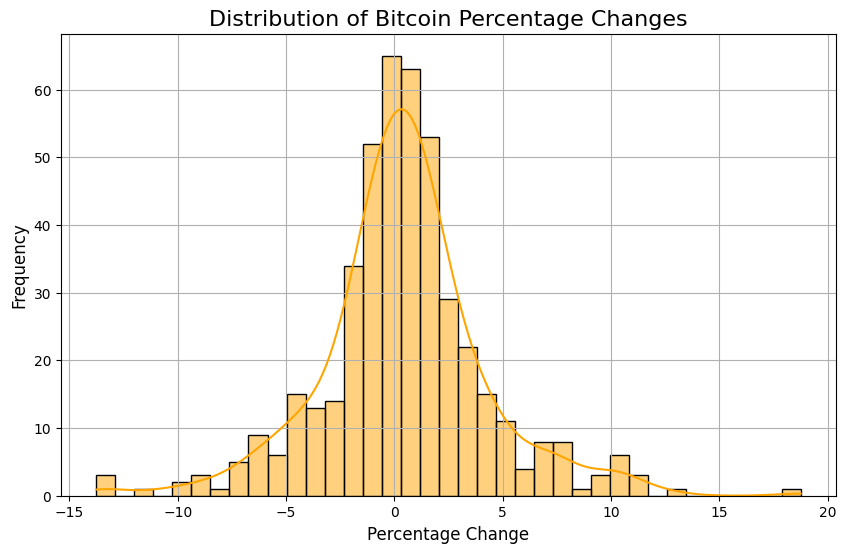

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the merged cryptocurrency dataset
merged_df = pd.read_csv('/content/drive/MyDrive/Python Project/merged_cryptos.csv', parse_dates=['Date'])

# Calculate the percentage change for Bitcoin and add it as a new column
merged_df['btc_pct_change'] = merged_df['btc_close'].pct_change() * 100

plt.figure(figsize=(10, 6))
sns.histplot(merged_df['btc_pct_change'], kde=True, color='orange')
plt.title('Distribution of Bitcoin Percentage Changes', fontsize=16)
plt.xlabel('Percentage Change', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid()
plt.savefig('btc_pct_change_distribution.png')
plt.show()

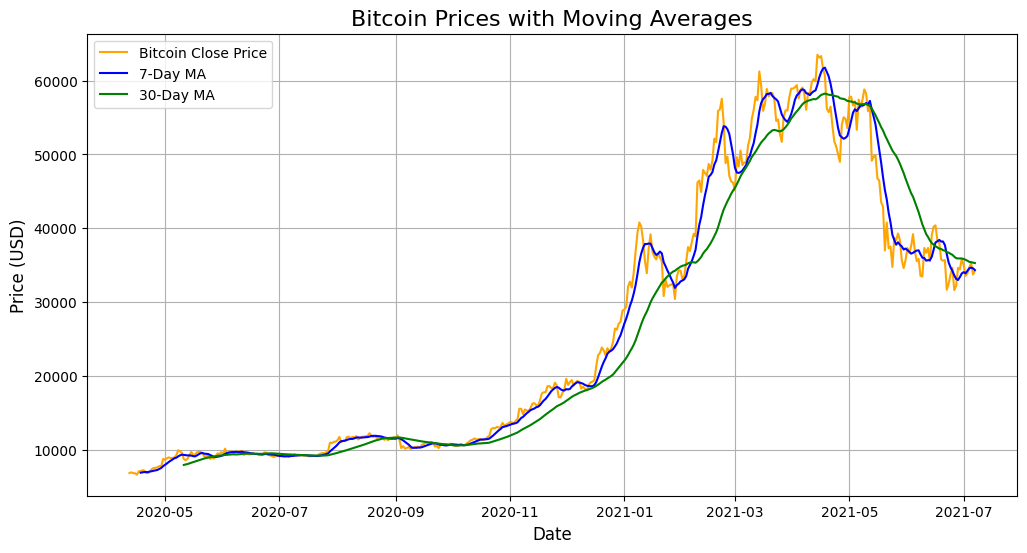

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the merged cryptocurrency dataset
merged_df = pd.read_csv('/content/drive/MyDrive/Python Project/merged_cryptos.csv', parse_dates=['Date'])

# Calculate the 7-day and 30-day moving averages for Bitcoin
merged_df['btc_ma7'] = merged_df['btc_close'].rolling(window=7).mean()  # Calculate 7-day MA
merged_df['btc_ma30'] = merged_df['btc_close'].rolling(window=30).mean() # Calculate 30-day MA


plt.figure(figsize=(12, 6))
plt.plot(merged_df['Date'], merged_df['btc_close'], label='Bitcoin Close Price', color='orange')
plt.plot(merged_df['Date'], merged_df['btc_ma7'], label='7-Day MA', color='blue')
plt.plot(merged_df['Date'], merged_df['btc_ma30'], label='30-Day MA', color='green')
plt.title('Bitcoin Prices with Moving Averages', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend()
plt.grid()
plt.savefig('btc_moving_averages.png')
plt.show()

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Load the merged cryptocurrency dataset
merged_df = pd.read_csv('/content/drive/MyDrive/Python Project/merged_cryptos.csv', parse_dates=['Date'])

# 1. Calculate Percentage Change
merged_df['btc_pct_change'] = merged_df['btc_close'].pct_change() * 100
merged_df['eth_pct_change'] = merged_df['eth_close'].pct_change() * 100
merged_df['sol_pct_change'] = merged_df['sol_close'].pct_change() * 100

# 2. Calculate Moving Averages
merged_df['btc_ma7'] = merged_df['btc_close'].rolling(window=7).mean()
merged_df['btc_ma30'] = merged_df['btc_close'].rolling(window=30).mean()

# 3. Assuming you have functions to calculate these indicators - replace with your actual calculations
#  For demonstration, I'm filling these with placeholder values - Make sure you implement these correctly
# Calculate Bollinger Bands
merged_df['btc_bbm'] = merged_df['btc_close'].rolling(window=20).mean()  # Placeholder - Replace with your calculation
merged_df['btc_bbh'] = merged_df['btc_bbm'] + 2 * merged_df['btc_close'].rolling(window=20).std()  # Placeholder
merged_df['btc_bbl'] = merged_df['btc_bbm'] - 2 * merged_df['btc_close'].rolling(window=20).std()  # Placeholder

# Calculate RSI
merged_df['btc_rsi'] = 0  # Placeholder - Replace with your calculation

# Calculate Lagged Features
merged_df['btc_lag1'] = merged_df['btc_close'].shift(1)
merged_df['eth_lag1'] = merged_df['eth_close'].shift(1)
merged_df['sol_lag1'] = merged_df['sol_close'].shift(1)

# 4. Define your target variable - Make sure you have 'btc_target' in your dataset
# For demonstration, I'm assuming a simple target - Replace with your logic
merged_df['btc_target'] = (merged_df['btc_close'].shift(-1) > merged_df['btc_close']).astype(int) # Example

# 5. Prepare training data after calculating all features and target
features = ['btc_pct_change', 'eth_pct_change', 'sol_pct_change', 'btc_ma7', 'btc_ma30',
            'btc_bbm', 'btc_bbh', 'btc_bbl', 'btc_rsi', 'btc_lag1', 'eth_lag1', 'sol_lag1']


<Figure size 1000x600 with 0 Axes>

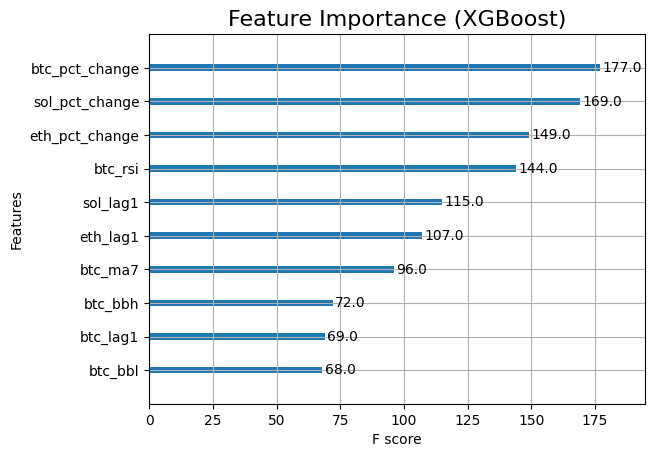

In [77]:
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model, max_num_features=10, importance_type='weight')
plt.title('Feature Importance (XGBoost)', fontsize=16)
plt.savefig('feature_importance_xgb.png')
plt.show()